# Bayesian statistics - extra practise

Notebook putting the excellent Machine lectures of Nando de Freitas in code/(LA)tex(t). We are dealing with Bayesian statistics. This is an extra notebook not covering any lectures of Nando.

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import scipy.stats as stats

PyMC3 is basically a collection of **theano** symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients. For practical purposes, what this means is that in order to build certain models we sometimes have to use theano.

In [35]:
PATH_DATA = 'C:\\Users\\Egbert\\datascience\\ubc_ml\\data\\'

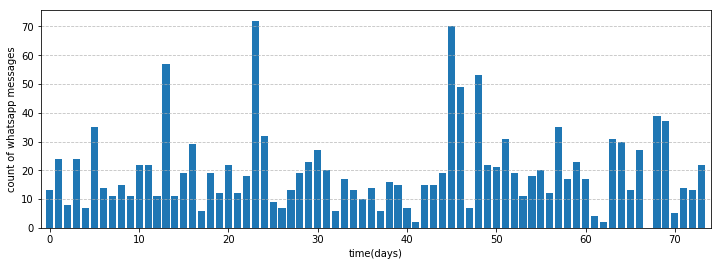

In [56]:
fig, ax = plt.subplots(figsize= [12,4])
whatsapp_count = np.loadtxt(PATH_DATA + 'txtdata.csv')
n_count_data = len(whatsapp_count)
ax.bar(np.arange(n_count_data), whatsapp_count)
ax.set(xlabel = 'time(days)', ylabel='count of whatsapp messages', xlim = (-1, n_count_data));
plt.grid(axis='y', linestyle= '--', alpha=.8)

Would you say there was a change in behaviour during this time period?
How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of count data. Denoting day $i$'s text-message count by $C_i$,
$$ C_i \sim \text{Poisson}(\lambda)  $$

(Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a switchpoint:
$$
\lambda = 
\begin{cases}
\lambda_1  \text{if } t \lt \tau \cr
\lambda_2  \text{if } t \ge \tau
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.


We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the exponential distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

$$\begin{align}
\lambda_1 \sim \text{Exp}( \alpha ) \\\
\lambda_2 \sim \text{Exp}( \alpha )
\end{align}$$

$\alpha$ is called a hyper-parameter or parent variable. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:
$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$
An alternative, and something I encourage the reader to try, would be to have two priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.
What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a uniform prior belief to every possible day. This is equivalent to saying

$$\begin{align}
\tau \sim \text{DiscreteUniform(1,70) }\\\\
\Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}$$

So after all this, what does our overall prior distribution for the unknown variables look like? Frankly, it doesn't matter. What we should understand is that it's an ugly, complicated mess involving symbols only a mathematician could love. And things will only get uglier the more complicated our models become. Regardless, all we really care about is the posterior distribution.
We next turn to PyMC3, a Python library for performing Bayesian analysis that is undaunted by the mathematical monster we have created.

In [59]:
with pm.Model() as model:
    alpha = 1.0/whatsapp_count.mean() # count of our whatsapp messages
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower =0 , upper= n_count_data -1)

In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's stochastic variables, so-called because they are treated by the back end as random number generators.

In [60]:
with model:
    idx = np.arange(n_count_data) # index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

This code creates a new function 'lambda', but really we can think of it as a random variable: the random variable $\lambda$ from above. The switch() function assigns lambda_1 or lambda_2 as the value of 'lambda', depending on what side of tau we are on. The values of 'lambda' up until tau are lambda_1 and the values afterwards are lambda_2.
Note that because lambda_1, lambda_2 and tau are random, 'lambda' will be random. We are not fixing any variables yet.

In [61]:
# The variable observation combines our data, count_data, with our proposed data-generation 
# scheme, given by the variable lambda_, through the observed keyword:
with model:
    observation = pm.Poisson('obs', lambda_, observed = whatsapp_count)

Markov Chain Monte Carlo (MCMC) returning thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$.

In [62]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|████████████████████████████████████| 15000/15000 [05:24<00:00, 46.19it/s]


In [63]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

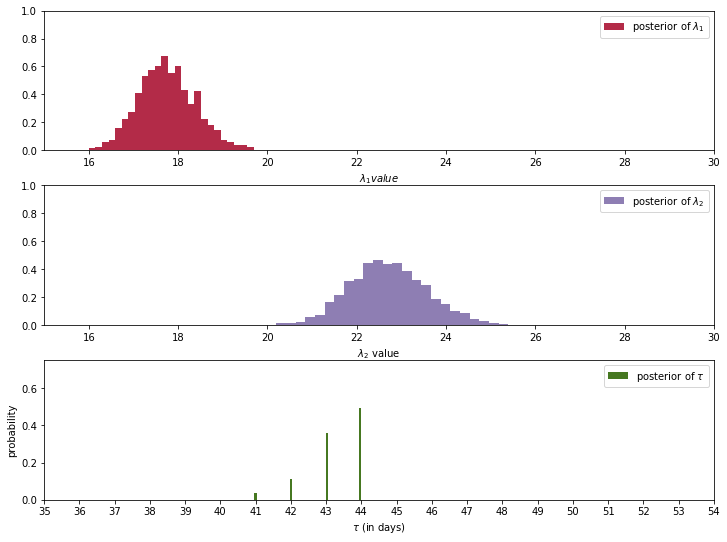

In [78]:
fig, ax  = plt.subplots(3,1, figsize= [12,9])
fig.subplots_adjust(hspace=0.25)

ax[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of $\lambda_1$", color="#A60628", normed=True)
ax[0].set(xlim = [15,30], ylim = [0,1], xlabel = '$\lambda_1 value$')
ax[0].legend(loc="upper right")

ax[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
ax[1].legend(loc="upper right")
ax[1].set(xlim = [15, 30], ylim = [0,1], xlabel = "$\lambda_2$ value")

w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
ax[2].hist(tau_samples, bins=n_count_data, alpha=1,
           label=r"posterior of $\tau$",
           color="#467821", weights=w, rwidth=2.)
ax[2].set(xticks = (np.arange(n_count_data)), ylim = [0, .75], xlim = [35, len(whatsapp_count)-20] ,
          xlabel = r"$\tau$ (in days)", ylabel = "probability");
ax[2].legend(loc="upper right");

**Interpretation**

Recall that Bayesian methodology returns a distribution. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this mathematically, we would have been stuck with an analytically intractable (c.q. messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a _discrete random variable_, so it doesn't assign probabilities to intervals. We can see that near day 44/45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points.

We'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to what is the expected value of $\lambda$ at time $t$?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$.

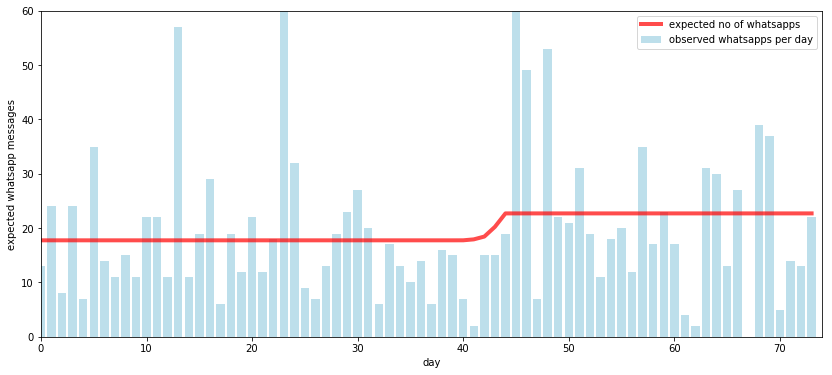

In [93]:
fig, ax  = plt.subplots(figsize= [14,6])

N = tau_samples.shape[0]
expected_whatsapps_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    """
    Each posterior sample corresponds to a value for tau.
    for each day, that value of tau indicates whether we're "before"
    (in the lambda1 "regime") or
    "after" (in the lambda2 "regime") the switchpoint.
    """
    ix = day < tau_samples
    expected_whatsapps_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N
    
ax.plot(range(n_count_data), expected_whatsapps_per_day, lw=4, color = 'red', alpha=.7 ,
        label ='expected no of whatsapps')
ax.bar(np.arange(len(whatsapp_count)), whatsapp_count, color="lightblue", alpha=0.8,
       label="observed whatsapps per day")
ax.set(xlim = [0, n_count_data], ylim = [0,60], xlabel ='day', ylabel = 'expected whatsapp messages')
ax.legend(loc = 'upper right')

### A/B testing

Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us.

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the observed frequency $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the observed frequency and the true frequency of an event.

To setup a Bayesian model, we need to assign prior distrbutions to our unknown quantities. A priori, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [95]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0 , upper=1) # bounds of the uniform

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a Bernoulli distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [99]:
p_true = .05 # this value is unknown in reality
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
occurrences = stats.bernoulli.rvs(p_true, size=N) # rvs: Random variates

In [100]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0540
Does this equal the true frequency? False


Let's combine these observations into the PyMC3 observed variable, and run inference algorithm:

In [104]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("observed", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|████████████████████████████████████| 18500/18500 [04:03<00:00, 76.09it/s]


At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like "What does my prior distribution of $\lambda_1$ look like?"

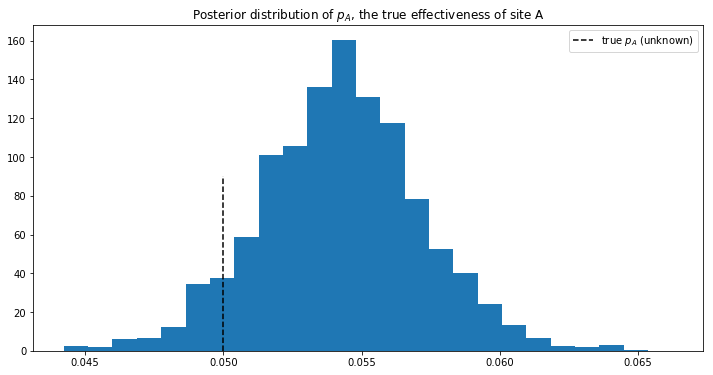

In [105]:
# plot the posterior distribution of the unknown P_A
fix, ax = plt.subplots(figsize= [12,6])
ax.vlines(p_true, 0, 90, linestyle = '--', label="true $p_A$ (unknown)")
ax.hist(burned_trace['p'], bins=25, histtype = 'stepfilled', normed= True)
ax.set(title = "Posterior distribution of $p_A$, the true effectiveness of site A")
ax.legend(loc='upper right')